In [2]:
import glob
import os
import time
import csv

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID' 
os.environ['CUDA_VISIBLE_DEVICES']='3'

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import h5py
import imageio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torchvision import datasets, transforms
# from torch.autograd import Variable
import torch.autograd as autograd
import torchvision.utils as vutils

from torch.utils.data import DataLoader, TensorDataset

In [3]:
def load_data():
    x_train = (h5py.File('camelyonpatch_level_2_split_train_x.h5', 'r')['x'][:, 16:80,16:80] - 127.5) / 127.5
    y_train = h5py.File('camelyonpatch_level_2_split_train_y.h5', 'r')['y'][:].reshape(-1,1)
    x_test = (h5py.File('camelyonpatch_level_2_split_test_x.h5', 'r')['x'][:, 16:80,16:80] - 127.5) / 127.5
    y_test = h5py.File('camelyonpatch_level_2_split_test_y.h5', 'r')['y'][:].reshape(-1,1)
    x_valid = (h5py.File('camelyonpatch_level_2_split_valid_x.h5', 'r')['x'][:, 16:80,16:80] - 127.5) / 127.5
    y_valid = h5py.File('camelyonpatch_level_2_split_valid_y.h5', 'r')['y'][:].reshape(-1,1)
              
    return x_train, y_train, x_test, y_test, x_valid, y_valid

def plot_samples(samples, folder=None, epoch=None, i=None):
    rt = int(np.sqrt(samples.shape[0]))
    r, c = rt, rt
    # r, c = 6, 12

    generatedImage = 0.5 * samples + 0.5

    fig = plt.figure(figsize=(10,10))

    axs = [fig.add_subplot(r,c,i+1) for i in range(r*c)]
    cnt = 0
    for ax in axs:
        ax.imshow(generatedImage[cnt],interpolation='nearest')
        ax.axis('off')
        ax.set_aspect('equal')
        cnt+=1
    fig.subplots_adjust(wspace=.004, hspace=.02)

    if folder:
        path = 'results/'+folder+'/samples'
        if not os.path.exists('results'):
            os.mkdir('results')
        if not os.path.exists('results/'+folder):
            os.mkdir('results/'+folder)
        if not os.path.exists(path):
            os.mkdir(path)
        step = ""
        if i:
            step = '_'+str(i)
        fig.savefig(path+'/epoch_%d%s.png' % (epoch, step))
        plt.close()


/home/aray/pathology_gan


(array([131072., 131072.]),
 array([0. , 0.5, 1. ], dtype=float32),
 <a list of 2 Patch objects>)

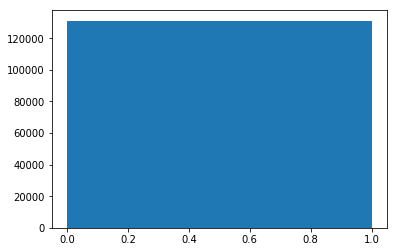

In [4]:
%cd "~/pathology_gan"

x_train, y_train, x_test, y_test, x_valid, y_valid = load_data()

x_train = torch.from_numpy(np.moveaxis(x_train.astype(np.float32), -1, 1))
x_test  = torch.from_numpy(np.moveaxis(x_test.astype(np.float32), -1, 1))
x_valid  = torch.from_numpy(np.moveaxis(x_valid.astype(np.float32), -1, 1))

y_train = torch.from_numpy(y_train).float() 
y_test = torch.from_numpy(y_test).float() 
y_valid = torch.from_numpy(y_valid).float() 

# X = torch.from_numpy(np.moveaxis(np.concatenate([x_train, x_test, x_valid]).astype(np.float32), -1, 1))
# y = torch.from_numpy(np.concatenate([y_train, y_test, y_valid]))

# trainloader = DataLoader(TensorDataset(x_train, y_train), batch_size=128, shuffle=True, num_workers=0, pin_memory=True)
validloader = DataLoader(TensorDataset(x_valid, y_valid), batch_size=128, shuffle=True, num_workers=0, pin_memory=True)

# percent = int(x_train.shape[0]*.8)
# np.random.seed(17)
# idx_small = np.random.choice(range(x_train.shape[0]), percent, replace=False)

x_train_small = x_train#[idx_small]
y_train_small = y_train#[idx_small]
trainloader = DataLoader(TensorDataset(x_train_small, y_train_small), batch_size=128, shuffle=True, num_workers=0, pin_memory=True)

plt.hist(y_train_small.numpy(), bins=2)
# print(percent)

In [5]:
y_train_small = y_train_small.type(torch.LongTensor)
y_valid=y_valid.type(torch.LongTensor)
trainloader = DataLoader(TensorDataset(x_train_small, y_train_small), batch_size=128, shuffle=True, num_workers=0, pin_memory=True)
validloader = DataLoader(TensorDataset(x_valid, y_valid), batch_size=128, shuffle=True, num_workers=0, pin_memory=True)


In [46]:
y_test=y_test.type(torch.LongTensor)
testloader = DataLoader(TensorDataset(x_test, y_test), batch_size=128, shuffle=True, num_workers=0, pin_memory=True)

In [5]:
# noise = np.random.normal(0,1,size=(16,100))
# imgs = saved_actor.predict(noise)
# plot_samples(imgs)

# imgs_real = .5+.5*np.moveaxis(x_train[np.random.choice(range(x_train.shape[0]), 12*6, replace=False)], -1, 1)
# plot_samples(x_train[np.random.choice(range(x_train.shape[0]), 12*6, replace=False)])
# print(imgs_real.shape)
# plt.figure(figsize=(24,12))
# plt.imshow(np.transpose(make_grid(torch.from_numpy(imgs_real), nrow=12, ).numpy(), (1, 2, 0)))

In [6]:
class Generator(nn.Module):
    def __init__(self, w, h, c, latent_dim):
        super(Generator, self).__init__()
        
        self.w = w
        self.h = h
        self.c = c
        self.latent_dim = latent_dim
        
        self.n_filters = 128
        
        self.input = nn.Sequential(
            nn.Linear(latent_dim, self.n_filters * w//4 * h//4),
            nn.ReLU()
        )
        
        self.deconv = nn.Sequential(
            nn.Upsample(size=[w//2, h//2], mode='nearest'),
            nn.Conv2d(self.n_filters, self.n_filters//2, 3, stride=1, padding=1),
            nn.ReLU(True),
            
            nn.Upsample(size=[w, h], mode='nearest'),
            nn.Conv2d(self.n_filters//2, self.n_filters//4, 4, stride=2, padding=1),
            nn.ReLU(True),
            
            nn.Upsample(size=[w, h], mode='nearest'),
            nn.Conv2d(self.n_filters//4, self.n_filters//8, 3, stride=1, padding=1),
            nn.ReLU(True),

            nn.Upsample(size=[w, h], mode='nearest'),
            nn.Conv2d(self.n_filters//8, self.n_filters//16, 4, stride=2, padding=1),
            nn.ReLU(True),

            nn.Upsample(size=[w, h], mode='nearest'),
            nn.Conv2d(self.n_filters//16, self.n_filters//32, 3, stride=1, padding=1),
            nn.ReLU(True),

            nn.Conv2d(self.n_filters//32, c, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        output = self.input(x)
        # print(output.shape)
        output = output.view(-1, self.n_filters, self.w//4, self.h//4)
        # print(output.shape)
        return self.deconv(output) #.view(-1, self.w, self.h, self.c)

class Discriminator(nn.Module):
    def __init__(self, h, w, c):
        super(Discriminator, self).__init__()
        
        self.w = w
        self.h = h
        self.c = c
        n_filters = 32

        self.conv = nn.Sequential(
            nn.Conv2d(c, n_filters, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(n_filters, 2*n_filters, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(2*n_filters, 4*n_filters, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten()
        )
        self.dropout=nn.Dropout(0.5)
        self.fc = nn.Linear(4*n_filters*int(w/2**3)*int(h/2**3), 2, bias=True)

    def forward(self, x, clf=True, dropout=True):
        flatten = self.conv(x)
        if dropout:
            flatten = self.dropout(flatten)
        
        out = self.fc(flatten)
        
        if clf:
            return F.softmax(out, dim=1)

#         expsum = torch.exp(out).sum(dim=1)
#         out = expsum/(expsum+1)
        return out, flatten



In [7]:
class SSL_WGAN:
    def __init__(self, w, h, c, model_name):
        self.model_name = model_name
        self.use_cuda = True
        self.D = Discriminator(w, h, c)

        lr = 1e-4
        betas = (.9, .99)

        self.Clf_opt = optim.Adam(self.D.parameters(), lr=lr/2, betas=betas)
        self.Clf_criterion = torch.nn.CrossEntropyLoss()
        
        if self.use_cuda:
            self.D = self.D.cuda()

        if not os.path.exists('results/'+model_name):
            os.mkdir('results/'+model_name)

    def train(self, train_loader, validation_loader, epochs, save_training_gif=True):

        self.stats = {
            'clf_loss': [],
            'clf_acc': [],
            'clf_loss_val': [],
            'clf_acc_val': [],
            
        }

        for epoch in range(epochs):
            clf_loss = []
            clf_acc = []

            for i, data in enumerate(train_loader):
                X = data[0]
                y = data[1].view(-1)
                if self.use_cuda:
                    X = X.cuda()
                    y = y.cuda()
                    
                loss, acc = self._train_Clf(X, y)
                clf_loss.append(loss)
                clf_acc.append(acc)                                
            
#             if epoch % 10 == 0:
            acc_val = self._eval_Clf(validation_loader)
            clf_loss_m = sum(clf_loss)/len(clf_loss)
            clf_acc_m = sum(clf_acc)/len(clf_acc)     
            self.stats['clf_loss'].append(clf_loss_m)
            self.stats['clf_acc'].append(clf_acc_m)
#             self.stats['clf_loss_val'].append(loss_val)
            self.stats['clf_acc_val'].append(acc_val)
            print("Epoch: %d, loss: %f, acc: %.3f, acc_val: %.3f"%(epoch, clf_loss_m, clf_acc_m, acc_val))
            


    def _eval_Clf(self, validation_loader):
        self.D.eval()        
        with torch.no_grad():
            acc = .0
            for i, data in enumerate(validation_loader):
                X = data[0]
                y = data[1].view(-1)
                if self.use_cuda:
                    X = X.cuda()
                    y = y.cuda()
                predicted = torch.argmax(self.D(X, dropout=False), dim=1)
                acc+=(predicted == y).sum()/float(predicted.shape[0])       
        self.D.train()
        return (acc/(i+1)).detach().item()

    def _train_Clf(self, data, labels):
        self.Clf_opt.zero_grad()
        
        predicted = self.D(data, clf=True, dropout=True)
    
        loss = self.Clf_criterion(predicted, labels)
        
        loss.backward()
        self.Clf_opt.step()    
      
        acc = (torch.argmax(predicted.detach().cpu(), dim=1) == labels.detach().cpu()).sum()/float(predicted.shape[0])

        return loss.detach().item(), acc


In [45]:
def eval_Clf(model, validation_loader):
    model.eval()        
    with torch.no_grad():
        acc = .0
        for i, data in enumerate(validation_loader):
            X = data[0].cuda()
            y = data[1].view(-1).cuda()
            predicted = torch.argmax(model(X, dropout=False), dim=1)
            acc+=(predicted == y).sum()/float(predicted.shape[0])       
    model.train()
    return (acc/(i+1)).detach().item()

In [50]:
eval_Clf(wgan_ct.D, testloader), eval_Clf(wgan_ct.D, validloader)

(0.79766845703125, 0.82208251953125)

In [51]:
eval_Clf(fake_clf.D, testloader), eval_Clf(fake_clf.D, validloader)

(0.800048828125, 0.803375244140625)

In [ ]:
%%time
wgan_ct = SSL_WGAN(64, 64, 3, 'clf')
wgan_ct.train(trainloader, validloader, 500, x_train.shape[0])

In [14]:
fake = h5py.File('fake.hdf5', 'r')['fake'][:]
fake = torch.from_numpy(np.moveaxis(fake.astype(np.float32), -1, 1))
fakeloader = DataLoader(fake, batch_size=128, pin_memory=True)

fake.shape

torch.Size([262144, 3, 64, 64])

In [32]:
wgan_ct.D.eval()
pred_fake = []
with torch.no_grad():
    for data in fakeloader:
        pred_fake.extend(wgan_ct.D(data.cuda(),dropout=False).cpu().numpy())
pred_fake = np.array(pred_fake)
pred_fake.shape

(262144, 2)

In [54]:
y_train = y_train.type(torch.LongTensor)
y_fake = y_fake.type(torch.LongTensor)

In [55]:
# idx_fake = np.any(pred_fake>0.9, axis=1)
# y_fake = torch.from_numpy(np.argmax(pred_fake[idx_fake], axis=1).reshape(-1,1)).type(torch.LongTensor)
# X_fake = fake[idx_fake]

trainmixedloader = DataLoader(TensorDataset(torch.cat([x_train, X_fake]), torch.cat([y_train, y_fake])), batch_size=128, shuffle=True, num_workers=0, pin_memory=True)



In [ ]:
%%time
fake_clf = SSL_WGAN(64, 64, 3, 'clf')
fake_clf.train(trainfakeloader, validloader, 500, X_fake.shape[0])

In [ ]:
%%time
mixed_clf = SSL_WGAN(64, 64, 3, 'clf')
mixed_clf.train(trainmixedloader, validloader, 500, X_fake.shape[0])

Epoch: 0, loss: 0.499694, acc: 0.804, acc_val: 0.774
Epoch: 1, loss: 0.465428, acc: 0.841, acc_val: 0.784
Epoch: 2, loss: 0.454222, acc: 0.853, acc_val: 0.796
Epoch: 3, loss: 0.448287, acc: 0.859, acc_val: 0.796
Epoch: 4, loss: 0.443609, acc: 0.864, acc_val: 0.796
Epoch: 5, loss: 0.440151, acc: 0.868, acc_val: 0.801
Epoch: 6, loss: 0.437896, acc: 0.870, acc_val: 0.802
Epoch: 7, loss: 0.436005, acc: 0.872, acc_val: 0.800
Epoch: 8, loss: 0.434404, acc: 0.874, acc_val: 0.803
Epoch: 9, loss: 0.432188, acc: 0.876, acc_val: 0.807
Epoch: 10, loss: 0.430399, acc: 0.878, acc_val: 0.805
Epoch: 11, loss: 0.429044, acc: 0.880, acc_val: 0.807


In [59]:
path = 'results/'+mixed_clf.model_name
with open(path+'/mixed_clf_fake_loss.csv', 'w', newline='') as myfile:
    wr = csv.writer(myfile)
    wr.writerow(mixed_clf.stats['clf_loss'])

with open(path+'/mixed_clf_fake_acc_val.csv', 'w', newline='') as myfile:
    wr = csv.writer(myfile)
    wr.writerow(mixed_clf.stats['clf_acc_val'])

with open(path+'/mixed_clf_fake_acc.csv', 'w', newline='') as myfile:
    wr = csv.writer(myfile)
    wr.writerow(mixed_clf.stats['clf_acc'])
    
# print(np.argmax(wgan_ct.stats['clf_acc_val']))
# wgan_ct.stats['clf_acc_val'][3]

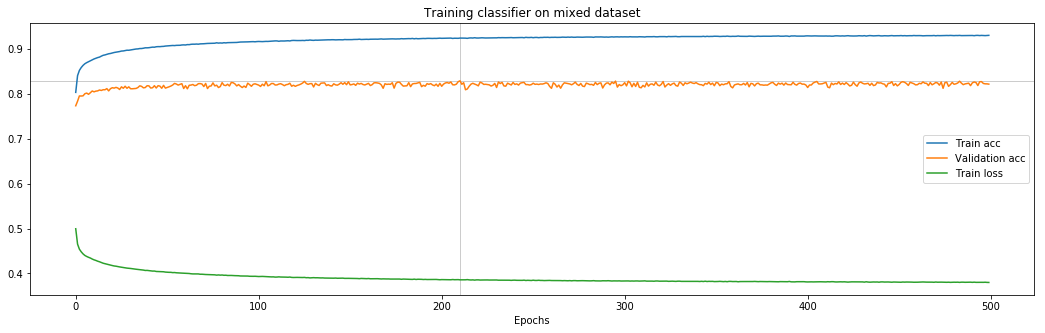

In [58]:
plt.figure(figsize=(18,5))
plt.title('Training classifier on mixed dataset')
acc_max = np.max(mixed_clf.stats['clf_acc_val'])
acc_max_e = np.argmax(mixed_clf.stats['clf_acc_val'])
plt.axhline(y=acc_max, color='k', linestyle='-', alpha=0.2, linewidth=1)
plt.axvline(x=acc_max_e, color='k', linestyle='-', alpha=0.2, linewidth=1)
plt.plot(mixed_clf.stats['clf_acc'], label='Train acc')
plt.plot(mixed_clf.stats['clf_acc_val'], label='Validation acc')
plt.plot(mixed_clf.stats['clf_loss'], label='Train loss')
plt.xlabel('Epochs')
plt.legend()

In [ ]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)

# ================== main script ======================

netG = Generator()
netG.apply(weights_init)
netD = Discriminator()
netD.apply(weights_init)

print netG
print netD

if use_cuda:
    netD = netD.cuda()
    netG = netG.cuda()

optimizerD = optim.Adam(netD.parameters(), lr=1e-4, betas=(0.5, 0.9))
optimizerG = optim.Adam(netG.parameters(), lr=1e-4, betas=(0.5, 0.9))

one = torch.FloatTensor([1])
mone = one * -1
zero = torch.FloatTensor([0])
if use_cuda:
    one = one.cuda()
    mone = mone.cuda()
    zero = zero.cuda()

def dataset():
    while 1:
        for images,targets in train_loader:
            #print(images)
            yield images
data=dataset()
fixed_noise = Variable(torch.randn(100, NOISE_SZ).cuda(),requires_grad = False)

for iteration in xrange(ITERS):
    ############################
    # (1) Update D network
    ###########################
    netD.train()
    for p in netD.parameters():  
        p.requires_grad = True  
    for iter_d in xrange(CRITIC_ITERS):
        _data = data.next()
        real_data = torch.Tensor(_data)
        if use_cuda:
            real_data = real_data.cuda()
        real_data_v = autograd.Variable(real_data)

        netD.zero_grad()


        # train with fake
        noise = torch.randn(BATCH_SIZE, NOISE_SZ)
        if use_cuda:
            noise = noise.cuda()
        noise_v = autograd.Variable(noise, volatile=True)  
        fake = autograd.Variable(netG(noise_v).data)
        D_fake1_1,D_fake1_2 = netD(fake)
        D_fake1 = D_fake1_1.mean()
        D_fake1.backward((one))

        # train with gradient penalty
        gradient_penalty = calc_gradient_penalty(netD, real_data_v.data, fake.data)
        gradient_penalty.backward()
               
        # train with real
        D_real1_1,D_real1_2 = netD(real_data_v)
        D_real1 = D_real1_1.mean()      
        D_real1.backward((mone),retain_graph=True)
        
        # train with CT penalty
        D_real2_1,D_real2_2 = netD(real_data_v)

        ct_penalty = LAMBDA_2*((D_real1_1-D_real2_1)**2)       
        ct_penalty += LAMBDA_2*0.1*((D_real1_2-D_real2_2)**2).mean(dim=1)
        ct_penalty = torch.max(Variable(torch.zeros(ct_penalty.size()).cuda() if use_cuda else torch.zeros(ct_penalty.size())),ct_penalty-Factor_M)
        ct_penalty = ct_penalty.mean()
        #print(ct_penalty)
        ct_penalty.backward()

        D_cost = -D_real1 + D_fake1 + gradient_penalty + ct_penalty
        #print(-D_real1.data[0] , D_fake1.data[0] , gradient_penalty.data[0] ,ct_penalty.data[0])
        #D_cost.backward()
        Wasserstein_D = D_real1 - D_fake1
        optimizerD.step()

    #if not FIXED_GENERATOR:
        ############################
        # (2) Update G network
        ###########################
    netD.eval()
    for p in netD.parameters():
        p.requires_grad = False  
    netG.zero_grad()

    noise = torch.randn(BATCH_SIZE, NOISE_SZ)
    if use_cuda:
        noise = noise.cuda()
    noisev = autograd.Variable(noise,requires_grad=True) 
    fake = netG(noisev)
    G,_ = netD(fake)
    G = G.mean()
    G.backward(mone)
    G_cost = -G
    optimizerG.step()
    print((iteration,D_cost.data[0],Wasserstein_D.data[0]))
    if iteration%100==0:
        fake = netG(fixed_noise).view(-1, 1,28,28)
        vutils.save_image(fake.data,
                    'fake_samples_epoch_%03d.png' %  iteration,
                    normalize=True)

torch.save(netG.state_dict(), 'netG_mnist.pth')
torch.save(netD.state_dict(), 'netD_mnist.pth')